In [1]:
import tensorflow as tf
import matplotlib
import keras
import matplotlib.pyplot as plt
import numpy as np
import os, time, scipy.io
import pathlib
import rawpy
import cv2
from IPython.display import Image
import glob
import PIL
import PIL.Image as plim

In [2]:
from PIL import Image


_errstr = "Mode is unknown or incompatible with input array shape."


def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)


def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

## TEST

In [3]:
# x = [1,2,3]
# tf.concat([x, x, x], axis=0)

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      # tf.debugging.set_log_device_placement(True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [5]:
# matplotlib.rcParams['figure.figsize'] = [9, 6]

In [6]:
# x = tf.linspace(-2, 2, 201)
# x = tf.cast(x, tf.float32)

# def f(x):
#   y = x**2 + 2*x - 5
#   return y

# y = f(x) + tf.random.normal(shape=[201])

# plt.plot(x.numpy(), y.numpy(), '.', label='Data')
# plt.plot(x, f(x),  label='Ground truth')
# plt.legend();

In [7]:
# class Model(tf.keras.Model):
#   def __init__(self, units):
#     super().__init__()
#     self.dense1 = tf.keras.layers.Dense(units=units,
#                                         activation=tf.nn.relu,
#                                         kernel_initializer=tf.random.normal,
#                                         bias_initializer=tf.random.normal)
#     self.dense2 = tf.keras.layers.Dense(1)

#   def call(self, x, training=True):
#     # For Keras layers/models, implement `call` instead of `__call__`.
#     x = x[:, tf.newaxis]
#     x = self.dense1(x)
#     x = self.dense2(x)
#     return tf.squeeze(x, axis=1)

In [8]:
# model = Model(64)

In [9]:
# plt.plot(x.numpy(), y.numpy(), '.', label='data')
# plt.plot(x, f(x),  label='Ground truth')
# plt.plot(x, model(x), label='Untrained predictions')
# plt.title('Before training')
# plt.legend();

In [10]:
# variables = model.variables

# optimizer = tf.optimizers.SGD(learning_rate=0.01)

# for step in range(1000):
#   with tf.GradientTape() as tape:
#     prediction = model(x)
#     error = (y-prediction)**2
#     mean_error = tf.reduce_mean(error)
#   gradient = tape.gradient(mean_error, variables)
#   optimizer.apply_gradients(zip(gradient, variables))

#   if step % 100 == 0:
#     print(f'Mean squared error: {mean_error.numpy():0.3f}')

In [11]:
# plt.plot(x.numpy(),y.numpy(), '.', label="data")
# plt.plot(x, f(x),  label='Ground truth')
# plt.plot(x, model(x), label='Trained predictions')
# plt.title('After training')
# plt.legend();

In [12]:
# new_model = Model(64)

In [13]:
# new_model.compile(
#     loss=tf.keras.losses.MSE,
#     optimizer=tf.optimizers.SGD(learning_rate=0.01))

# history = new_model.fit(x, y,
#                         epochs=100,
#                         batch_size=32,
#                         verbose=0)

# new_model.save('my_model')

In [14]:
# plt.plot(history.history['loss'])
# plt.xlabel('Epoch')
# plt.ylim([0, max(plt.ylim())])
# plt.ylabel('Loss [Mean Squared Error]')
# plt.title('Keras training progress');

## LSD

In [15]:
input_dir = './dataset/Sony/short/'
gt_dir = './dataset/Sony/long/'
checkpoint_dir = './result_Sony/'
result_dir = './result_Sony/'

target_fns = glob.glob(gt_dir + '0*.ARW')
print(target_fns)
target_ids = [int(os.path.basename(target_fn)[0:5]) for target_fn in target_fns]

train_fns = glob.glob(input_dir + '%05d_0?*.ARW' % target_ids[0])

train_ids = [int(os.path.basename(train_fn)[0:5]) for train_fn in train_fns]

['./dataset/Sony/long\\00001_00_10s.ARW', './dataset/Sony/long\\00002_00_10s.ARW', './dataset/Sony/long\\00004_00_10s.ARW', './dataset/Sony/long\\00009_00_10s.ARW', './dataset/Sony/long\\00010_00_10s.ARW', './dataset/Sony/long\\00012_00_10s.ARW', './dataset/Sony/long\\00013_00_10s.ARW', './dataset/Sony/long\\00014_00_10s.ARW', './dataset/Sony/long\\00015_00_10s.ARW']


In [16]:
# train patch size
ps = 512
save_freq = 4
leaky_relu_layer = tf.keras.layers.LeakyReLU(0.2)
tf.data.Dataset.cache
tf.data.Dataset.prefetch

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.prefetch(self, buffer_size, name=None)>

In [17]:
print([os.path.basename(target_fn) for target_fn in target_fns])
print(target_ids)
print(20*'-')
print([os.path.basename(train_fn) for train_fn in train_fns])
print(train_ids)

['00001_00_10s.ARW', '00002_00_10s.ARW', '00004_00_10s.ARW', '00009_00_10s.ARW', '00010_00_10s.ARW', '00012_00_10s.ARW', '00013_00_10s.ARW', '00014_00_10s.ARW', '00015_00_10s.ARW']
[1, 2, 4, 9, 10, 12, 13, 14, 15]
--------------------
['00001_00_0.04s.ARW', '00001_00_0.1s.ARW', '00001_01_0.04s.ARW', '00001_01_0.1s.ARW', '00001_02_0.1s.ARW', '00001_03_0.1s.ARW', '00001_04_0.1s.ARW', '00001_05_0.1s.ARW', '00001_06_0.1s.ARW', '00001_07_0.1s.ARW', '00001_08_0.1s.ARW', '00001_09_0.1s.ARW']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[512, 512, 512, 512]
(2848, 4256, 3)


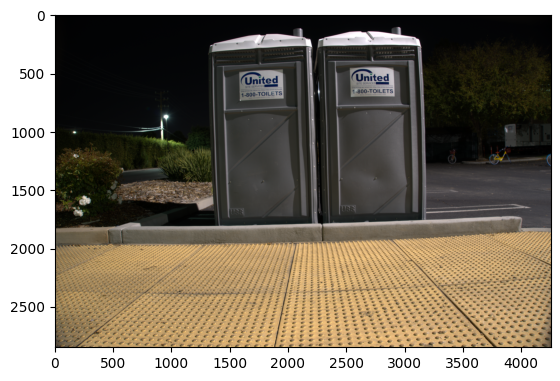

In [18]:
im = rawpy.imread(f'{target_fns[0]}')
print(im.black_level_per_channel)
im_p = im.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True)
print(np.shape(im_p))
plt.imshow(im_p)
None

## Build MODEL

In [19]:
def double_conv(x, n_filters):
    x1 = tf.keras.layers.Conv2D(n_filters, [3,3], padding = 'SAME', activation = leaky_relu_layer, kernel_initializer = 'random_normal')(x)
    x2 = tf.keras.layers.Conv2D(n_filters, [3,3], padding = 'SAME', activation = leaky_relu_layer, kernel_initializer = 'random_normal')(x1)
    return x2

def downsample_block(x, n_filters):
    f = double_conv(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2, padding = 'SAME')(f)
    #  p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x1, n_filters, x2 = None):
    pool_size = 2 
    # output_chanel = n_filter
    input_channels = n_filters*2
    
    deconv_filter = tf.Variable(tf.random.truncated_normal([pool_size, pool_size, n_filters, input_channels], stddev = 0.02))
    # print(deconv_filter)
    # print('x2 down_conw',tf.shape(x2))
    # print('x1 up_conw',tf.shape(x1))
    x = tf.keras.layers.Conv2DTranspose(n_filters, pool_size, strides = (pool_size, pool_size),padding='same')(x1)
    print(np.shape(x))
    x = tf.concat([x, x2], 3)
    x.set_shape([None, None, None, n_filters * 2])
    
    #  x = tf.keras.layers.Dropout(0.3)(x)
    x = double_conv(x, n_filters)
    return x

def build_unet_model():
    inputs = tf.keras.layers.Input(shape=(None,None,4))
    
    conv_1, p1 = downsample_block(inputs, 32)
    conv_2, p2 = downsample_block(p1, 64)
    conv_3, p3 = downsample_block(p2, 128)
    conv_4, p4 = downsample_block(p3, 256)
    
    conv_5 = double_conv(p4, 512)
    
    conv_6 = upsample_block(conv_5, 256, conv_4)
    conv_7 = upsample_block(conv_6, 128,  conv_3)
    conv_8 = upsample_block(conv_7, 64, conv_2)
    conv_9 = upsample_block(conv_8, 32, conv_1)
    conv_10 = tf.keras.layers.Conv2D(12, 1, padding="same", activation = None)(conv_9)
    out = tf.nn.depth_to_space(conv_10, 2)
    unet_model = tf.keras.Model(inputs, out, name="U-Net")
    return unet_model

(None, None, None, 256)
(None, None, None, 128)
(None, None, None, 64)
(None, None, None, 32)
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1184        ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 


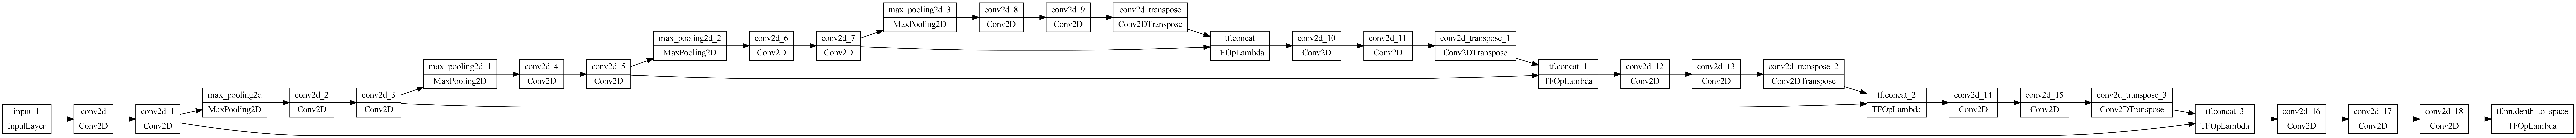

In [20]:
unet_model = build_unet_model()
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)
unet_model.compile(optimizer, keras.losses.MeanAbsoluteError())
# unet_model.load_weights(filepath="./result_Sony/check_points/tfmodel.ckpt018")
unet_model.summary()
tf.keras.utils.plot_model(unet_model, rankdir="LR", dpi = 400)

In [21]:
def pack_raw(raw):
  im = raw.raw_image_visible.astype(np.float32)
  im = np.maximum(im - 512, 0)/(16383 - 512)
  im = np.expand_dims(im, axis = 2)
  # print(np.shape(im))
  img_shape = im.shape
  H = img_shape[0]
  W = img_shape[1]

  out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
  # print(np.shape(out))
  return out
#разделяет raw на RGBG каналы
def divide_layers(layer, channel):
  only_one_layer = []
  for i in range(len(layer)):
    first_layer = []
    for j in range(len(layer[0])):
      first_layer.append(layer[i][j][channel])
    only_one_layer.append(first_layer)
  return only_one_layer

def print_subplot(ax, channel, color_space, name):
  ax.imshow(channel, cmap = color_space)
  ax.set_title(name)
def print_image(image):
  image = np.array(image)
  R, G_1, B, G= cv2.split(image)
  fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(1, 4, figsize = [20, 10])
  print_subplot(ax_1, R, 'Reds', 'Red_channel')
  print_subplot(ax_2, G_1, 'Greens', 'Green_channel')
  print_subplot(ax_3, B, 'Blues', 'Blue_channel')
  print_subplot(ax_4, G, 'Greens', 'Green_2_channel')

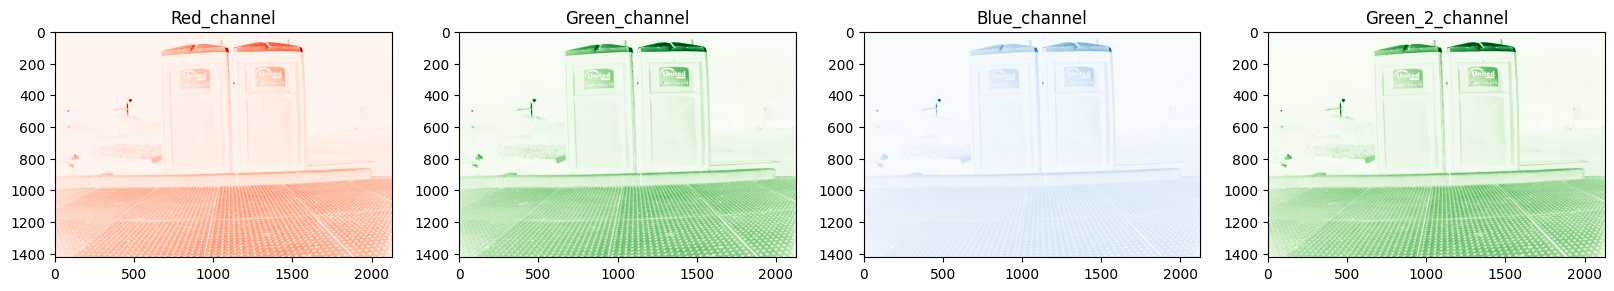

In [22]:
image = pack_raw(im)
print_image(image)

In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
    ])

In [24]:
# a = np.expand_dims(pack_raw(im), axis=0)
# # print(tf.shape(im))
# print(tf.shape(a))
# print(tf.shape(im_p))
# gt_images = np.expand_dims(np.float32(im_p / 65535.0), axis=0)
# print(tf.shape(gt_images))
#H = a.shape[1]
# W = a.shape[2]

# xx = np.random.randint(0, W - ps*2)
# yy = np.random.randint(0, H - ps*2)
# input_patch = a[:, yy:yy + ps, xx:xx + ps, :]
# a = a[:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]
# print(tf.shape(input_patch))
# print(tf.shape(a))

In [25]:
weights = unet_model.get_weights() 
print(np.array(weights[12]).shape)
def get_config(self):
    config = super().get_config()
    return config

(3, 3, 128, 256)


In [26]:
@tf.function
def run_optimization(x,y):
    with tf.GradientTape() as g:
        prediction = unet_model(x)
        # print(prediction)
        loss = tf.reduce_mean(tf.abs(prediction - y))
    with tf.device('/:GPU:0'):
        trainable_variables = unet_model.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [27]:
gt_images = [None] * 6000
input_images = {}
input_images['300'] = [None] * len(target_ids)
input_images['250'] = [None] * len(target_ids)
input_images['100'] = [None] * len(target_ids)
cnt = 0
for epoch in range(1, 20):
    for ind in np.random.permutation(len(target_ids)):
        st = time.time()
        target_id = target_ids[ind]
        in_files = glob.glob(input_dir + '%05d_0?*.ARW' % target_id)
        in_path = in_files[np.random.randint(0, len(in_files))]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % target_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        if input_images[str(ratio)[0:3]][ind] is None:
            raw = rawpy.imread(in_path)
            input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)
            
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]
        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]
        
        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))
        input_patch = np.minimum(input_patch, 1.0)
        loss = run_optimization(input_patch, gt_patch)
        print(f'loss{loss}, index {ind}, epoch {epoch}')
        if epoch % 100 == 0:
            output = unet_model(input_patch)  
            output = np.minimum(np.maximum(output, 0), 1)
            if not os.path.isdir(result_dir + '%04d' % epoch):
                os.makedirs(result_dir + '%04d' % epoch)
            temp = np.concatenate((gt_patch[0, :, :, :], output[0, :, :, :]), axis=1)
            toimage(temp * 255, high=255, low=0, cmin=0, cmax=255, mode = 'RGB').save(
                result_dir + '%04d/%05d_00_train_%d.png' % (epoch, target_id, ratio))

    if epoch % save_freq == 0 or epoch == 1:
        cnt +=1
        output = unet_model(input_patch)  
        output = np.minimum(np.maximum(output, 0), 1)
        if not os.path.isdir(result_dir + '%04d' % epoch):
            os.makedirs(result_dir + '%04d' % epoch)
        temp = np.concatenate((gt_patch[0, :, :, :], output[0, :, :, :]), axis=1)
        toimage(temp * 255, high=255, low=0, cmin=0, cmax=255, mode = 'RGB').save(
            result_dir + '%04d/%05d_00_train_%d.png' % (epoch, target_id, ratio))
        unet_model.save(filepath=result_dir + "check_points/keras_model/kerasmodel%03d.keras" % cnt)
    print(f'epoch: {epoch}, time: { "{:.4f}".format(time.time() - st)}s')

loss0.20571433007717133, index 0, epoch 1
loss0.23251675069332123, index 2, epoch 1
loss0.1840614676475525, index 3, epoch 1
loss0.08066943287849426, index 4, epoch 1
loss0.19117186963558197, index 1, epoch 1
loss0.1358557492494583, index 8, epoch 1
loss0.10229378193616867, index 5, epoch 1
loss0.23529420793056488, index 7, epoch 1
loss0.21931679546833038, index 6, epoch 1


C:\Users\maksi\AppData\Local\Temp\ipykernel_25440\2496767527.py:160: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()


epoch: 1, time: 3.6801s
loss0.10337524861097336, index 0, epoch 2
loss0.1504264771938324, index 6, epoch 2
loss0.22936946153640747, index 1, epoch 2
loss0.05899101123213768, index 4, epoch 2
loss0.1485179364681244, index 2, epoch 2
loss0.1592593491077423, index 3, epoch 2
loss0.17205585539340973, index 5, epoch 2
loss0.1619715541601181, index 7, epoch 2
loss0.05196607485413551, index 8, epoch 2
epoch: 2, time: 0.5561s
loss0.16387151181697845, index 2, epoch 3
loss0.13952945172786713, index 7, epoch 3
loss0.05435552820563316, index 4, epoch 3
loss0.1085289940237999, index 3, epoch 3
loss0.17148828506469727, index 6, epoch 3
loss0.12367638200521469, index 5, epoch 3
loss0.22661690413951874, index 1, epoch 3
loss0.13066120445728302, index 0, epoch 3
loss0.060842063277959824, index 8, epoch 3
epoch: 3, time: 1.7914s
loss0.15096226334571838, index 5, epoch 4
loss0.13265937566757202, index 2, epoch 4
loss0.052254196256399155, index 0, epoch 4
loss0.09836375713348389, index 6, epoch 4
loss0.1

In [31]:
unet_model.save(filepath=result_dir + "check_points/keras_model/kerasmodel%03d.keras" % 20)

In [33]:
test_fn = glob.glob('./Sony/' + '*.ARW')
print(test_fn)
im = rawpy.imread(f'{test_fn[0]}')
raw = pack_raw(im)
for i in range(3):
    for j in range(5): 
        crop = raw[512*i:512*(i+1), 512*j:512*(j+1), :]
        test = np.expand_dims(crop, axis=0) * 50
        out_im = unet_model(test)
        out_im = np.minimum(np.maximum(out_im, 0), 1)
        toimage(out_im[0] * 255, high=255, low=0, cmin=0, cmax=255, mode = 'RGB').save(
                    result_dir + "test_my_data/test_keras_model_save/" + f'{int(os.path.basename(test_fn[0])[4:8])}_{i}{j}.png')

['./Sony\\00031_06_0.1s.ARW']


C:\Users\maksi\AppData\Local\Temp\ipykernel_25440\2496767527.py:160: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()


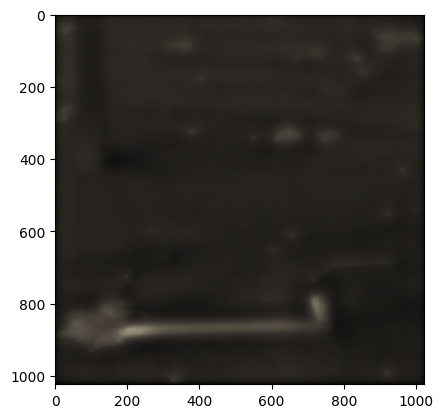

In [30]:
out_im = np.minimum(np.maximum(out_im, 0), 1)
plt.imshow(out_im[0])